# Planning-Lab Lesson 3: Markov Decision Process

In the third session we will work on the Markov decision process (MDP)

## Lava environments
The environments used are LavaFloor (visible in the figure) and its variations.

![Lava](images/lava.png)

The agent starts in cell $(0, 0)$ and has to reach the treasure in $(2, 3)$. In addition to the walls of the previous environments, the floor is covered with lava, there is a black pit of death.

Moreover, the agent can't comfortably perform its actions that instead have a stochastic outcome (visible in the figure):

![Dynact](images/dynact.png)

The action dynamics is the following:
- $P(0.8)$ of moving **in the desired direction**
- $P(0.1)$ of moving in a direction 90° with respect to the desired direction

Finally, since the floor is covered in lava, the agent receives a negative reward for each of its steps!

- -0.04 for each lava cell (L)
- -5 for the black pit (P). End of episode
- +1 for the treasure (G). End of episode

In [4]:
import os, sys, random
module_path = os.path.abspath(os.path.join('../tools'))
if module_path not in sys.path:
    sys.path.append(module_path)

import gym, envs
from utils.ai_lab_functions import *
from timeit import default_timer as timer
from tqdm import tqdm as tqdm

### Environment Properties 

In addition to the varables of the environments you have been using in the previous sessions, there are also a few more:

- $T$: matrix of the transition function $T(s, a, s') \rightarrow [0, 1]$
- $RS$: matrix of the reward function $R(s) \rightarrow \mathbb{R}$

The available actions are still Left, Right, Up, Down.

#### Code Hints:

In [5]:
env = gym.make("LavaFloor-v0")

current_state = env.pos_to_state(0, 0)
next_state = env.pos_to_state(0, 1)
goal_state = env.pos_to_state(2, 3)

print("Number of actions: ", env.action_space.n)
print("Actions: ", env.actions)
print("Reward of starting state:", env.RS[current_state])
print("Reward of goal state:", env.RS[goal_state])
print("Probability from (0, 0) to (0, 1) with action right:", env.T[current_state, 1, next_state])
print("Probability from (0, 0) to (2, 3) with action right:", env.T[current_state, 1, goal_state])

Number of actions:  4
Actions:  {0: 'L', 1: 'R', 2: 'U', 3: 'D'}
Reward of starting state: -0.04
Reward of goal state: 1.0
Probability from (0, 0) to (0, 1) with action right: 0.8
Probability from (0, 0) to (2, 3) with action right: 0.0


In [6]:
env_name = "LavaFloor-v0"
env = gym.make(env_name)

c=0
state_right = env.pos_to_state(0, 1) #state to the tight of start state
for i in range(1,101):
    current_state = env.pos_to_state(0, 0)
    state = env.sample(current_state, 1) #trying to go right
    if (state==state_right): 
        c+=1 #counting how many times the agent reaches the state to the right
        
#computing percentage of time agent reached the state to the right going right, should be around 80%           
print("percentage of time agent reaches the state to the right: ", c/i*100) 

print("Transition model for ", env_name, " : ") #assume transition functions is the same for all states
state=0
next_state=1
for i in range(0,env.action_space.n):
    print("probability of reaching ", env.state_to_pos(next_state), "from ", env.state_to_pos(state), " executing action ", env.actions[i], " : ", env.T[state, i, next_state])
print("Reward for non terminal states: ",env.RS[env.pos_to_state(0,0)]) #assume all states have same reward
for state in range(0,env.observation_space.n):
    if env.grid[state] == "P" or env.grid[state] == "G":
                    print("Reward for state :", env.state_to_pos(state) ," (state type: ", env.grid[state],") : ",env.RS[state])


percentage of time agent reaches the state to the right:  76.0
Transition model for  LavaFloor-v0  : 
probability of reaching  (0, 1) from  (0, 0)  executing action  L  :  0.0
probability of reaching  (0, 1) from  (0, 0)  executing action  R  :  0.8
probability of reaching  (0, 1) from  (0, 0)  executing action  U  :  0.1
probability of reaching  (0, 1) from  (0, 0)  executing action  D  :  0.1
Reward for non terminal states:  -0.04
Reward for state : (1, 3)  (state type:  P ) :  -5.0
Reward for state : (2, 3)  (state type:  G ) :  1.0


## Assignment 1: Value Iteration Algorithm

Your first assignment is to implement the Value Iteration algorithm on LavaFloor. The solution returned by your algorithm must be a 1-d array of action identifiers where the $i$-th action refers to the $i$-th state.  You can perform all the test on a different versions of the environment, but with the same structure: *HugeLavaFloor*, *NiceLavaFloor* and *VeryBadLavaFloor*.

<img src="images/value-iteration.png" width="600">

The *value_iteration* function has to be implemented. Notice that the value iteration approach return a matrix with the value for eacht state, the function *values_to_policy* automatically convert this matrix in the policy.

In [7]:
def value_iteration(environment, maxiters=300, discount=0.9, max_error=1e-3):
    """
    Performs the value iteration algorithm for a specific environment
    
    Args:
        environment: OpenAI Gym environment
        maxiters: timeout for the iterations
        discount: gamma value, the discount factor for the Bellman equation
        max_error: the maximum error allowd in the utility of any state
        
    Returns:
        policy: 1-d dimensional array of action identifiers where index `i` corresponds to state id `i`
    """
    
    U_1 = [0 for _ in range(environment.observation_space.n)] # vector of utilities for states S
    delta = 0 # maximum change in the utility o any state in an iteration
    U = U_1.copy()
    #
    # Code Here!
    #

    while True:
        maxiters -= 1
        U = U_1.copy()
        diff = 0
        for s in range (0,environment.observation_space.n):
            if environment.grid[s] == "P" or environment.grid[s] == "G":
                U_1[s] = environment.RS[s] 
            else:
                maxV = - np.inf
                for a in range (0,environment.action_space.n): 
                    tot = 0
                    for s1 in range (0,environment.observation_space.n):
                        tot += environment.T[s,a,s1]*U[s1]
                    maxV = max(maxV,tot)
                U_1[s] = environment.RS[s] + maxV*discount
            diff = max(abs(U_1[s] - U[s]),diff)
        
        if (diff < (max_error*(1-discount)/discount)) or (maxiters < 0):
            break
        
    return values_to_policy(np.asarray(U), environment) # automatically convert the value matrix U to a policy

**The following code executes Value Iteration and prints the resulting policy**

In [19]:
#env_name = "LavaFloor-v0"
#env_name = "HugeLavaFloor-v0"
env_name = "NiceLavaFloor-v0"
#env_name = "VeryBadLavaFloor-v0"



env = gym.make(env_name)
print("\nENV RENDER:")
env.render()

print("Transition model for ", env_name, " : ") #assume transition functions is the same for all states
state=0
next_state=1
for i in range(0,env.action_space.n):
    print("probability of reaching ", env.state_to_pos(next_state), "from ", env.state_to_pos(state), " executing action ", env.actions[i], " : ", env.T[state, i, next_state])
print("Reward for non terminal states: ",env.RS[env.pos_to_state(0,0)]) #assume all states have same reward
for state in range(0,env.observation_space.n):
    if env.grid[state] == "P" or env.grid[state] == "G":
                    print("Reward for state :", env.state_to_pos(state) ," (state type: ", env.grid[state],") : ",env.RS[state])

t = timer()
policy = value_iteration(env)

print("\nEXECUTION TIME: \n{}".format(round(timer() - t, 4)))
policy_render = np.vectorize(env.actions.get)(policy.reshape(env.rows, env.cols))
results = CheckResult_L3(env_name, policy_render)
results.check_value_iteration()


ENV RENDER:
[['S' 'L' 'L' 'L']
 ['L' 'W' 'L' 'P']
 ['L' 'L' 'L' 'G']]
Transition model for  NiceLavaFloor-v0  : 
probability of reaching  (0, 1) from  (0, 0)  executing action  L  :  0.0
probability of reaching  (0, 1) from  (0, 0)  executing action  R  :  0.8
probability of reaching  (0, 1) from  (0, 0)  executing action  U  :  0.1
probability of reaching  (0, 1) from  (0, 0)  executing action  D  :  0.1
Reward for non terminal states:  50.0
Reward for state : (1, 3)  (state type:  P ) :  -50.0
Reward for state : (2, 3)  (state type:  G ) :  5.0

EXECUTION TIME: 
0.0521

#################################################################
#######  Environment: NiceLavaFloor-v0 	Value Iteration  ########
#################################################################

===> Your solution is correct!

Policy:
[['L' 'L' 'L' 'U']
 ['L' 'L' 'L' 'L']
 ['L' 'L' 'L' 'L']]


## Assignment 2: Policy Iteration Algorithm (<span style="color:red">*OPTIONAL*</span>)

Your <span style="color:red"> *optional*</span> assignment is to implement the Policy Iteration algorithm on LavaFloor. The solution returned by your algorithm must be a 1-d array of action identifiers where the $i$-th action refers to the $i$-th state. You can perform all the test on a different versions of the environment, but with the same structure: *HugeLavaFloor*, *NiceLavaFloor* and *VeryBadLavaFloor*.

<img src="images/policy-iteration.png" width="600">

For the *policy evaluation step*, it is necessary to implement this function:

<img src="images/policy-evaluating.png" width="500">

**The following function has to be implemented:**

In [47]:
def policy_iteration(environment, maxiters=150, discount=0.9, maxviter=10):
    """
    Performs the policy iteration algorithm for a specific environment
    
    Args:
        environment: OpenAI Gym environment
        maxiters: timeout for the iterations
        discount: gamma value, the discount factor for the Bellman equation
        
    Returns:
        policy: 1-d dimensional array of action identifiers where index `i` corresponds to state id `i`
    """
    # Step (1): Policy Evaluation
    #
    # Code Here!
    #
    policy = [0 for _ in range(environment.observation_space.n)] #initial policy
    U = [0 for _ in range(environment.observation_space.n)] #utility array
    while (True):
        maxiters-=1
        iter = maxviter
        while iter > 0 :
            iter -= 1
            for s in range (0, environment.observation_space.n):
                if environment.grid[s] == "P" or environment.grid[s] == "G":
                    U[s] = environment.RS[s] 
                else:
                    tot = 0
                    for s1 in range (0,environment.observation_space.n):
                        tot += environment.T[s,policy[s],s1]*U[s1]
                    U[s] =environment.RS[s] + tot*discount  
                      
    # Step (2) Policy Improvement
        unchanged = True  
        for s in range (0,environment.observation_space.n):
            max_act = 0
            maxV = - np.inf
            if environment.grid[s] not in ['P','G']:
                for a in range(0,environment.action_space.n):
                    tot = 0
                    for s1 in range(0,environment.observation_space.n):
                        tot+= environment.T[s,a,s1]*U[s1]
                    if tot > maxV :
                        maxV = tot
                        max_act = a
                tot2 = 0
                for s2 in range(0,environment.observation_space.n):
                    tot2 += environment.T[s,policy[s],s2]*U[s2]
                if maxV > tot2:
                    unchanged = False
                    policy[s] = max_act

        if (maxiters < 0) or unchanged:
            break
    #
    # Code Here!
    #
    
    return np.asarray(policy)

**The following code executes and Value Iteration and prints the resulting policy**

In [53]:
#env_name = "LavaFloor-v0"
#env_name = "HugeLavaFloor-v0"
#env_name = "NiceLavaFloor-v0"
env_name = "VeryBadLavaFloor-v0"

env = gym.make(env_name)
print("\nENV RENDER:")
env.render()

print("Transition model for ", env_name, " : ") #assume transition functions is the same for all states
state=0
next_state=1
for i in range(0,env.action_space.n):
    print("probability of reaching ", env.state_to_pos(next_state), "from ", env.state_to_pos(state), " executing action ", env.actions[i], " : ", env.T[state, i, next_state])
print("Reward for non terminal states: ",env.RS[env.pos_to_state(0,0)]) #assume all states have same reward
for state in range(0,env.observation_space.n):
    if env.grid[state] == "P" or env.grid[state] == "G":
                    print("Reward for state :", env.state_to_pos(state) ," (state type: ", env.grid[state],") : ",env.RS[state])

t = timer()
policy = policy_iteration(env)

print("\nEXECUTION TIME: \n{}".format(round(timer() - t, 4)))
policy_render = np.vectorize(env.actions.get)(policy.reshape(env.rows, env.cols))
results = CheckResult_L3(env_name, policy_render)
results.check_policy_iteration()


ENV RENDER:
[['S' 'L' 'L' 'L']
 ['L' 'W' 'L' 'P']
 ['L' 'L' 'L' 'G']]
Transition model for  VeryBadLavaFloor-v0  : 
probability of reaching  (0, 1) from  (0, 0)  executing action  L  :  0.0
probability of reaching  (0, 1) from  (0, 0)  executing action  R  :  0.8
probability of reaching  (0, 1) from  (0, 0)  executing action  U  :  0.1
probability of reaching  (0, 1) from  (0, 0)  executing action  D  :  0.1
Reward for non terminal states:  -5.0
Reward for state : (1, 3)  (state type:  P ) :  -5.0
Reward for state : (2, 3)  (state type:  G ) :  1.0

EXECUTION TIME: 
0.0064

##################################################################
#######  Environment: VeryBadLavaFloor-v0 	Policy Iteration  ########
##################################################################

===> Your solution is correct!

Policy:
[['R' 'R' 'R' 'D']
 ['D' 'L' 'R' 'L']
 ['R' 'R' 'R' 'L']]


## Comparison

The following code performs a comparison between Value Iteration and Policy Iteration, by plotting the accumulated rewards of each episode with iterations in range $[1, 50]$ (might take a long time if not optimizied via numpy). You can perform all the test on a different versions of the environment, but with the same structure: *HugeLavaFloor*.

The function **run_episode(envirnonment, policy, max_iteration)** run an episode on the given environment using the input policy.

Transition model for  LavaFloor-v0  : 
probability of reaching  (0, 1) from  (0, 0)  executing action  L  :  0.0
probability of reaching  (0, 1) from  (0, 0)  executing action  R  :  0.8
probability of reaching  (0, 1) from  (0, 0)  executing action  U  :  0.1
probability of reaching  (0, 1) from  (0, 0)  executing action  D  :  0.1
Reward for non terminal states:  -0.04
Reward for state : (1, 5)  (state type:  P ) :  -10.0
Reward for state : (3, 2)  (state type:  P ) :  -10.0
Reward for state : (3, 8)  (state type:  P ) :  -10.0
Reward for state : (6, 2)  (state type:  P ) :  -10.0
Reward for state : (6, 9)  (state type:  P ) :  -10.0
Reward for state : (7, 5)  (state type:  P ) :  -10.0
Reward for state : (9, 0)  (state type:  P ) :  -10.0
Reward for state : (9, 9)  (state type:  G ) :  10.0


Value Iteration:   0%|          | 0/50 [00:00<?, ?it/s]

Policy Iteration: 100%|██████████| 50/50 [00:01<00:00, 38.44it/s]


Execution time: 2.4776s


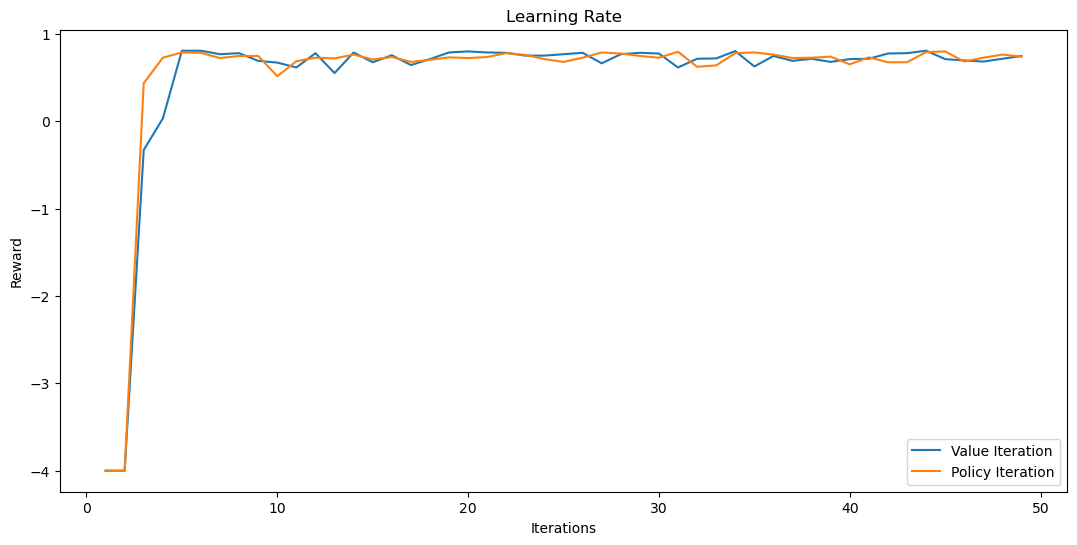

In [26]:
env_name = "LavaFloor-v0"
#env_name = "HugeLavaFloor-v0"

print("Transition model for ", env_name, " : ") #assume transition functions is the same for all states
state=0
next_state=1
for i in range(0,env.action_space.n):
    print("probability of reaching ", env.state_to_pos(next_state), "from ", env.state_to_pos(state), " executing action ", env.actions[i], " : ", env.T[state, i, next_state])
print("Reward for non terminal states: ",env.RS[env.pos_to_state(0,0)]) #assume all states have same reward
for state in range(0,env.observation_space.n):
    if env.grid[state] == "P" or env.grid[state] == "G":
                    print("Reward for state :", env.state_to_pos(state) ," (state type: ", env.grid[state],") : ",env.RS[state])



maxiters = 49

env = gym.make(env_name)

series = []  # Series of learning rates to plot
liters = np.arange(maxiters + 1)  # Learning iteration values
liters[0] = 1
elimit = 100  # Limit of steps per episode
rep = 10  # Number of repetitions per iteration value
virewards = np.zeros(len(liters))  # Rewards array
c = 0

t = timer()

# Value iteration
for i in tqdm(liters, desc="Value Iteration", leave=True):
    reprew = 0
    policy = value_iteration(env, maxiters=i)  # Compute policy
        
    # Repeat multiple times and compute mean reward
    for _ in range(rep):
        reprew += run_episode(env, policy, elimit)  # Execute policy
    virewards[c] = reprew / rep
    c += 1
series.append({"x": liters, "y": virewards, "ls": "-", "label": "Value Iteration"})


vmaxiters = 5  # Max number of iterations to perform while evaluating a policy
pirewards = np.zeros(len(liters))  # Rewards array
c = 0

# Policy iteration
for i in tqdm(liters, desc="Policy Iteration", leave=True):
    reprew = 0
    policy = policy_iteration(env, maxiters=i)  # Compute policy
    # Repeat multiple times and compute mean reward
    for _ in range(rep):
        reprew += run_episode(env, policy, elimit)  # Execute policy
    pirewards[c] = reprew / rep
    c += 1
series.append({"x": liters, "y": pirewards, "ls": "-", "label": "Policy Iteration"})

print("Execution time: {0}s".format(round(timer() - t, 4)))
np.set_printoptions(linewidth=10000)

plot(series, "Learning Rate", "Iterations", "Reward")

Correct results for comparison can be found here below. Notice that since the executions are stochastic the charts could differ: the important thing is the global trend and the final convergence to an optimal solution.

**Standard Lava floor results comparison**
<img src="images/results-standard.png" width="600">

**Huge Lava floor results comparison** 
<img src="images/results-huge.png" width="600">